In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys, re, math, random
import xml.etree.ElementTree as ET

In [2]:
def xml_to_dict(element):
    result = {**element.attrib} if element.attrib else {}
    if len(element):
        # Create a dictionary for the child elements
        children = []
        for child in element:
            # Recursively convert each child and update the dictionary
            children.append(xml_to_dict(child))
        result[element.tag] = children
    else:
        # If no children, just store the text content
        result[element.tag] = element.text.strip() if element.text else None
    return result
def parse_xml_to_dict(file):
    tree = ET.parse(file)
    root = tree.getroot()
    return xml_to_dict(root)
def display_problem(tensor, answer=None):
    # show the 3x3 grid of images
    images = tensor#.numpy()
    first_nine = images[:9].copy()
    first_nine[8] = np.zeros(images[8].shape) if answer is None else images[8 + answer].copy()
    fig, ax = plt.subplots(3, 3)
    for a in ax.ravel():
        a.set_aspect('equal')
    fig.set_facecolor('lightgray')
    for i in range(3):
        for j in range(3):
            ax[i, j].imshow(first_nine[i * 3 + j], cmap='gray')
            ax[i, j].axis('off')
    plt.show()
    print(f"Correct answer: {answer}")
    # Show the 8 possible answers
    fig, ax = plt.subplots(2, 4)
    for a in ax.ravel():
        a.set_aspect('equal')
    fig.set_facecolor('lightgray')
    for i in range(2):
        for j in range(4):
            ax[i, j].imshow(images[8 + i * 4 + j], cmap='gray')
            ax[i, j].axis('off')
    plt.show()

['RAVEN/new_data/center_single/RAVEN_4_train', 'RAVEN/new_data/center_single/RAVEN_8_test', 'RAVEN/new_data/center_single/RAVEN_7_val', 'RAVEN/new_data/center_single/RAVEN_5_train', 'RAVEN/new_data/center_single/RAVEN_6_val', 'RAVEN/new_data/center_single/RAVEN_1_train', 'RAVEN/new_data/center_single/RAVEN_9_test', 'RAVEN/new_data/center_single/RAVEN_0_train', 'RAVEN/new_data/center_single/RAVEN_2_train', 'RAVEN/new_data/center_single/RAVEN_3_train']
RAVEN/new_data/center_single/RAVEN_8_test


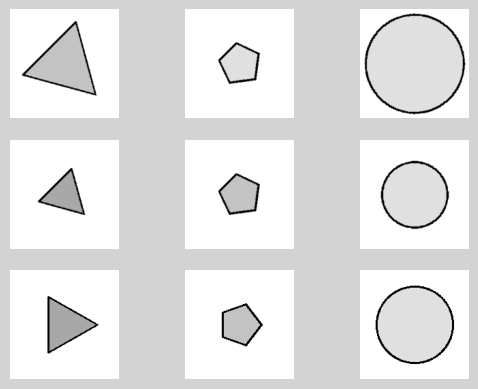

Correct answer: 5


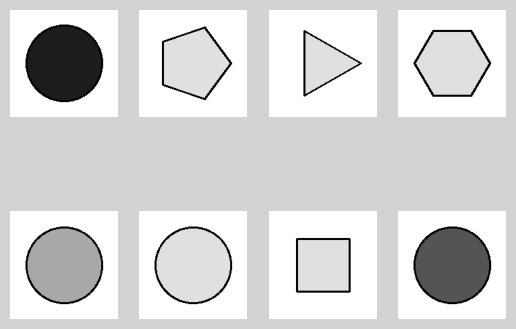

[[0, 0, 1, 4, 2, 0], [0, 1, 3, 0, 1, 0], [0, 2, 5, 5, 1, 0], [1, 0, 1, 1, 3, 0], [1, 1, 3, 0, 2, 0], [1, 2, 5, 2, 1, 0], [2, 0, 1, 2, 3, 1], [2, 1, 3, 0, 2, 1], [2, 2, 5, 3, 8, 1], [2, 2, 3, 3, 1, 1], [2, 2, 1, 3, 1, 1], [2, 2, 4, 3, 1, 1], [2, 2, 5, 3, 3, 1], [2, 2, 5, 3, 1, 1], [2, 2, 2, 3, 1, 1], [2, 2, 5, 3, 6, 1]]


In [4]:

# Read in an image's XML data
path = 'RAVEN/new_data'
subtype = 'center_single'
items = [x.split('.xml')[0] for x in glob.glob(os.path.join(path, subtype, '*.xml'))]
print(items)
item = items[1]
print(item)
img_loc = item + '.npz'

# Read the .npz file
data = np.load(f'{item}.npz')
display_problem(data['image'], data['target'])
answer = data['target'] # or target
# for i in range(data['image'].shape[0]):
#     plt.imshow(data['image'][i])
#     plt.show()
# Read the .xml file
data = parse_xml_to_dict(f'{item}.xml')
embeddings = []
for i in range(16):
    obj = data['Data'][0]['Panels'][i]['Panel'][0]['Struct'][0]['Component'][0]['Layout'][0]
    shape, size, color, angle = obj['Type'], obj['Size'], obj['Color'], obj['Angle']
    shape, size, color, angle = int(shape), int(size), int(color), int(angle)
    # print(obj)
    row = i // 3
    col = i % 3
    if i > 8:
        row, col = 2, 2
    
    embedding = [row, col, shape, size, color, angle]
    embeddings.append(embedding)
print(embeddings)
# tree = ET.parse(f'{item}.xml')
# root = tree.getroot()
# print(root[0].tag)

# # Example: print the root tag and its attributes
# print(f"Root tag: {root.tag}, attributes: {root.attrib}")

# # Iterate over child elements
# for child in root:
#     print(f"Tag: {child.tag}, Attributes: {child.attrib}, Text: {child.text}")

# # Find specific elements (for example, all 'item' tags)
# for item in root.findall('item'):
#     name = item.find('name').text  # Assuming 'name' is a sub-element
#     price = item.find('price').text  # Assuming 'price' is a sub-element
#     print(f"Item: {name}, Price: {price}")

In [5]:
row1 = [0, 1, 2]
row2 = [3, 4, 5]
row3 = [6, 7, 8 + answer]
for i in row1:
    print(embeddings[i])
print()
for i in row2:
    print(embeddings[i])
print()
for i in row3:
    print(embeddings[i])
# find some consistency for each row
def constant(i):
    def f(data):
        if len(np.array(data).shape) == 3:
            grid = data
            # we have a 2d matrix of embeddings
            num_rows = np.array(grid).shape[0]
            return all(all(grid[row_i][col_i][i] == grid[row_i][0][i] for col_i in range(3)) for row_i in range(num_rows))
        row = data
        return row[0][i] == row[1][i] == row[2][i]
    return f
def progression(i):
    def f(data):
        if len(np.array(data).shape) == 3:
            grid = data
            # we have a 2d matrix of embeddings
            num_rows = np.array(grid).shape[0]
            for delta in [1, -1, 2, -2]:
                if all(grid[row_i][0][i] + delta == grid[row_i][1][i] and grid[row_i][1][i] + delta == grid[row_i][2][i] for row_i in range(num_rows)):
                    return True
            return False
        row = data
        return row[0][i] == row[1][i] + 1 and row[1][i] == row[2][i] + 1
    return f
def arithmetic(i):
    def f(data):
        if len(np.array(data).shape) == 3:
            grid = data
            num_rows = np.array(grid).shape[0]
            constant = 0 if i == 4 else 1
            for sign in [1, -1]:
                # col1 + sign * col2 = col3
                if all(grid[row_i][0][i] + sign * (grid[row_i][1][i] + constant) == grid[row_i][2][i] for row_i in range(num_rows)):
                    return True
        return False
    return f
def distribute_three(i):
    def f(data):
        if len(np.array(data).shape) == 3:
            grid = data
            num_rows = np.array(grid).shape[0]
            # we have a 2d matrix of embeddings
            values = [set([grid[row_i][col_i][i] for col_i in range(3)]) for row_i in range(num_rows)]
            if len(values[0]) != 3:
                return False
            return all(values[row_i] == values[0] for row_i in range(num_rows))
        row = data
        return row[0][i] != row[1][i] and row[1][i] != row[2][i] and row[0][i] != row[2][i]
    return f
def noise(i):
    def f(row):
        return True
    return f

# Find what rule applies to each attribute
attribute_names = ['row', 'col', 'shape', 'size', 'color', 'angle']
rule_order = [constant, progression, arithmetic, distribute_three, noise]
rows = [row1, row2, row3]
rows = [[embeddings[j] for j in row] for row in rows]
row1, row2, row3 = rows
final_rules = {}
for attribute in range(2, 6):
    for rule in rule_order:
        if rule(attribute)([row1, row2]):
            final_rules[attribute] = rule
            print(f'Attribute {attribute_names[attribute]} follows rule {rule.__name__}')
            break
# Guess which item is correct
guess_scores = [0 for _ in range(8)]
for guess in range(8):
    guess_index = 8 + guess
    guess_embedding = embeddings[guess_index]
    row3 = [row3[0], row3[1], guess_embedding]
    flag = True
    for rule_i, (attribute, rule) in enumerate(final_rules.items()):
        if not rule(attribute)([row1, row2, row3]):
            flag = False
            # print(f'Guess {guess} is incorrect with embedding {guess_embedding} from attribute {attribute_names[attribute]}[{attribute}] with rule {rule.__name__}')
            # break
        else:
            guess_scores[guess] += 1
    if flag:
        print(f'My guess is {guess} with embedding {guess_embedding}')
print("Correct answer is", answer, "which is", embeddings[8 + answer])

[0, 0, 1, 4, 2, 0]
[0, 1, 3, 0, 1, 0]
[0, 2, 5, 5, 1, 0]

[1, 0, 1, 1, 3, 0]
[1, 1, 3, 0, 2, 0]
[1, 2, 5, 2, 1, 0]

[2, 0, 1, 2, 3, 1]
[2, 1, 3, 0, 2, 1]
[2, 2, 5, 3, 1, 1]
Attribute shape follows rule progression
Attribute size follows rule arithmetic
Attribute color follows rule arithmetic
Attribute angle follows rule constant
My guess is 5 with embedding [2, 2, 5, 3, 1, 1]
Correct answer is 5 which is [2, 2, 5, 3, 1, 1]
